# Benchmarking Against LCU Block-Encodings

In [1]:
from openparticle import ParticleOperator
import numpy as np
import cirq
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../../../'))
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../../'))
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../'))
from src.lobe.system import System
from pauli_lcu import lcuify, piecewise_lcu
from colors import *
from openparticle import generate_matrix
from src.lobe._utils import get_basis_of_full_system, get_bosonic_exponents
from src.lobe.bosonic import bosonic_product_block_encoding, bosonic_product_plus_hc_block_encoding 
from tests._utils import _validate_block_encoding

/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-21 12:55:38,258	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
def lobeify(operator, max_bosonic_occupancy):
    active_indices, exponents_list = get_bosonic_exponents(operator.to_list()[0])
    number_of_be_ancillae = len(active_indices)

    expected_rescaling_factor = 1
    for exponents in exponents_list:
        if exponents != (0, 0):
            expected_rescaling_factor *= (np.sqrt(max_bosonic_occupancy))**sum(exponents)

    if len(operator) == 1:
        be_func = bosonic_product_block_encoding
    else:
        be_func = bosonic_product_plus_hc_block_encoding
        number_of_be_ancillae += 1
        expected_rescaling_factor *= 2

    ctrls = ([cirq.LineQubit(-1000000)], [1])
    clean_ancillae = [cirq.LineQubit(-i-1) for i in range(100)]
    block_encoding_ancillae = [cirq.LineQubit(0 + i) for i in range(number_of_be_ancillae)]
    circuit = cirq.Circuit()
    system = System(max_bosonic_occupancy, 1000, 0, operator.max_bosonic_mode + 1)
    circuit.append(cirq.X.on(ctrls[0][0]))
    gates, metrics = be_func(
        system,
        block_encoding_ancillae,
        active_indices=active_indices,
        exponents_list=exponents_list,
        clean_ancillae=clean_ancillae,
        ctrls=ctrls
    )
    circuit += gates
    circuit.append(cirq.X.on(ctrls[0][0]))
    if max_bosonic_occupancy < 31:
        _validate_block_encoding(circuit,
            system,
            expected_rescaling_factor,
            operator,
            number_of_be_ancillae,
            max_bosonic_occupancy,
            max_qubits=16,
            using_pytest=False
        )
    return metrics, expected_rescaling_factor, number_of_be_ancillae, system.number_of_system_qubits

## Scaling of Single Operator with $\Omega$

In [3]:
def _2_norm(operator, max_bosonic_occupancy):
    full_fock_basis = get_basis_of_full_system(
        max_bosonic_occupancy,
        0,
        operator.max_bosonic_mode + 1,
    )
    expected_unitary = generate_matrix(operator, full_fock_basis)
    return np.linalg.norm(expected_unitary, ord=2)

def _max_column_norm(operator, max_bosonic_occupancy):
    full_fock_basis = get_basis_of_full_system(
        max_bosonic_occupancy,
        0,
        operator.max_bosonic_mode + 1,
    )
    expected_unitary = generate_matrix(operator, full_fock_basis)

    max_column_norm = 0
    for i in range(expected_unitary.shape[0]):
        column = expected_unitary[:, i]
        column_norm = 0
        for val in column:
            column_norm += np.abs(val)**2
        column_norm = np.sqrt(column_norm)
        max_column_norm = max(column_norm, max_column_norm)
        
    return max_column_norm

In [4]:
omegas = [1, 3, 7, 15, 31]

LCU_DATA = []
LOBE_DATA = []
operator_norms = []
max_column_norms = []

operator = ParticleOperator("a0")

for omega in omegas:
    print(f"-------{omega}------")

    print("LCU")
    LCU_DATA.append(lcuify(operator, omega, zero_threshold=1e-15))
    print("LOBE")
    LOBE_DATA.append(lobeify(operator, omega))

    operator_norms.append(_2_norm(operator, omega))
    max_column_norms.append(_max_column_norm(operator, omega))

-------1------
LCU
LOBE
-------3------
LCU
LOBE
-------7------
LCU
LOBE
-------15------
LCU
Testing singular quantum state for circuit with 12 qubits
LOBE
-------31------
LCU
Testing singular quantum state for circuit with 15 qubits
LOBE


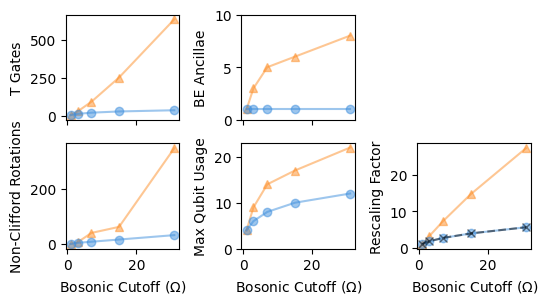

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(14 / 2.54, 8 / 2.54))

axes[0][0].plot(omegas, [(4*LCU_DATA[i][0].number_of_elbows) + LCU_DATA[i][0].number_of_t_gates for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5)
axes[0][0].plot(omegas, [(4*LOBE_DATA[i][0].number_of_elbows) + LOBE_DATA[i][0].number_of_t_gates for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5)
axes[0][0].set_ylabel("T Gates")
axes[0][0].set_xticklabels([])

axes[1][0].plot(omegas, [LCU_DATA[i][0].number_of_nonclifford_rotations for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5)
axes[1][0].plot(omegas, [LOBE_DATA[i][0].number_of_nonclifford_rotations for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5)
axes[1][0].set_ylabel("Non-Clifford Rotations")
axes[1][0].set_xlabel("Bosonic Cutoff ($\Omega$)")

axes[0][1].plot(omegas, [LCU_DATA[i][2] for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5)
axes[0][1].plot(omegas, [LOBE_DATA[i][2] for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5)
axes[0][1].set_ylabel("BE Ancillae")
axes[0][1].set_xticklabels([])
axes[0][1].set_yticks([0, 5, 10])

axes[1][1].plot(omegas, [LCU_DATA[i][0].ancillae_highwater() + LCU_DATA[i][2] + LCU_DATA[i][3] + 1 for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5, label="LCU")
axes[1][1].plot(omegas, [LOBE_DATA[i][0].ancillae_highwater() + LOBE_DATA[i][2] + LOBE_DATA[i][3] + 1 for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5, label="LOBE")
axes[1][1].plot([], [], color="black", marker='x', ls='--', alpha = 0.5, label="Hamiltonian Norm")
axes[1][1].set_ylabel("Max Qubit Usage")
axes[1][1].set_xlabel("Bosonic Cutoff ($\Omega$)")
axes[1][1].set_yticks([0, 10, 20])

axes[1][2].plot(omegas, [LCU_DATA[i][1] for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 0.5)
axes[1][2].plot(omegas, [LOBE_DATA[i][1] for i in range(len(omegas))], color=BLUE, marker='o', alpha = 0.5)
axes[1][2].plot(omegas, operator_norms, color="black", marker='x', ls='--', alpha = 0.5, label="Hamiltonian Norm")
axes[1][2].set_ylabel("Rescaling Factor")
axes[1][2].set_xlabel("Bosonic Cutoff ($\Omega$)")


fig.delaxes(axes[0][2])
plt.tight_layout()
# axes[0][1].legend(loc='upper center', bbox_to_anchor=(1.5, 0.75),
#           fancybox=True, shadow=True, ncol=1)
# plt.savefig("../../../manuscript/figures/bosonic-comparison.pdf", dpi=300)

## Scaling of Operator with Number of Active Modes

In [6]:
omega = 3
numbers_of_active_modes = range(1, 5)

LCU_DATA = []
LCU_PIECEWISE_DATA = []
LOBE_DATA = []

operator_norms = []
max_column_norms = []

for number_of_active_modes in numbers_of_active_modes:
    print(f"-------{number_of_active_modes}------")
    operator = ParticleOperator("")
    for mode in range(number_of_active_modes):
        operator *= ParticleOperator(f"a{mode}")
    operator += operator.dagger()

    print("LCU - Naive")
    LCU_DATA.append(lcuify(operator, omega))
    print("LCU - Piecewise")
    LCU_PIECEWISE_DATA.append(piecewise_lcu(operator, omega, zero_threshold=1e-15))
    print("LOBE")
    LOBE_DATA.append(lobeify(operator, omega))
    
    operator_norms.append(_2_norm(operator, omega))
    max_column_norms.append(_max_column_norm(operator, omega))

-------1------
LCU - Naive
LCU - Piecewise
LOBE
-------2------
LCU - Naive
LCU - Piecewise
Testing singular quantum state for circuit with 14 qubits
LOBE
-------3------
LCU - Naive
Too many qubits to validate: 16
LCU - Piecewise
Too many qubits to validate: 19
LOBE
Testing singular quantum state for circuit with 14 qubits
-------4------
LCU - Naive
Too many qubits to validate: 21
LCU - Piecewise
Too many qubits to validate: 24
LOBE
Too many qubits to validate: 17


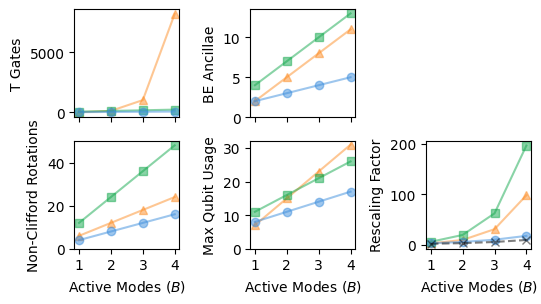

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(14 / 2.54, 8 / 2.54))

axes[0][0].plot(numbers_of_active_modes, [(4*LCU_DATA[i][0].number_of_elbows) + LCU_DATA[i][0].number_of_t_gates for i in range(len(numbers_of_active_modes))], color=ORANGE, marker='^', alpha = 0.5)
axes[0][0].plot(numbers_of_active_modes, [(4*LCU_PIECEWISE_DATA[i][0].number_of_elbows) + LCU_PIECEWISE_DATA[i][0].number_of_t_gates for i in range(len(numbers_of_active_modes))], color=GREEN, marker='s', alpha = 0.5)
axes[0][0].plot(numbers_of_active_modes, [(4*LOBE_DATA[i][0].number_of_elbows) + LOBE_DATA[i][0].number_of_t_gates for i in range(len(numbers_of_active_modes))], color=BLUE, marker='o', alpha = 0.5)
axes[0][0].set_ylabel("T Gates")
axes[0][0].set_xticks([1, 2, 3, 4])
axes[0][0].set_xticklabels([])

axes[1][0].plot(numbers_of_active_modes, [LCU_DATA[i][0].number_of_nonclifford_rotations for i in range(len(numbers_of_active_modes))], color=ORANGE, marker='^', alpha = 0.5)
axes[1][0].plot(numbers_of_active_modes, [LCU_PIECEWISE_DATA[i][0].number_of_nonclifford_rotations for i in range(len(numbers_of_active_modes))], color=GREEN, marker='s', alpha = 0.5)
axes[1][0].plot(numbers_of_active_modes, [LOBE_DATA[i][0].number_of_nonclifford_rotations for i in range(len(numbers_of_active_modes))], color=BLUE, marker='o', alpha = 0.5)
axes[1][0].set_ylabel("Non-Clifford Rotations")
axes[1][0].set_xlabel("Active Modes ($B$)")
axes[1][0].set_xticks([1, 2, 3, 4])
axes[1][0].set_yticks([0, 20, 40])

axes[0][1].plot(numbers_of_active_modes, [LCU_DATA[i][2] for i in range(len(numbers_of_active_modes))], color=ORANGE, marker='^', alpha = 0.5)
axes[0][1].plot(numbers_of_active_modes, [LCU_PIECEWISE_DATA[i][2] for i in range(len(numbers_of_active_modes))], color=GREEN, marker='s', alpha = 0.5)
axes[0][1].plot(numbers_of_active_modes, [LOBE_DATA[i][2] for i in range(len(numbers_of_active_modes))], color=BLUE, marker='o', alpha = 0.5)
axes[0][1].set_ylabel("BE Ancillae")
# axes[0][1].set_yticks([0, 5, 10])
axes[0][1].set_xticks([1, 2, 3, 4])
axes[0][1].set_xticklabels([])
axes[0][1].set_yticks([0, 5, 10])

axes[1][2].plot(numbers_of_active_modes, [LCU_DATA[i][1] for i in range(len(numbers_of_active_modes))], color=ORANGE, marker='^', alpha = 0.5)
axes[1][2].plot(numbers_of_active_modes, [LCU_PIECEWISE_DATA[i][1] for i in range(len(numbers_of_active_modes))], color=GREEN, marker='s', alpha = 0.5)
axes[1][2].plot(numbers_of_active_modes, [LOBE_DATA[i][1] for i in range(len(numbers_of_active_modes))], color=BLUE, marker='o', alpha = 0.5)
axes[1][2].plot(numbers_of_active_modes, operator_norms, color="black", marker='x', ls='--', alpha = 0.5, label="Hamiltonian Norm")
axes[1][2].set_ylabel("Rescaling Factor")
axes[1][2].set_xlabel("Active Modes ($B$)")
axes[1][2].set_xticks([1, 2, 3, 4])

axes[1][1].plot(numbers_of_active_modes, [LCU_DATA[i][0].ancillae_highwater() + LCU_DATA[i][2] + LCU_DATA[i][3] + 1 for i in range(len(numbers_of_active_modes))], color=ORANGE, marker='^', alpha = 0.5, label="LCU")
axes[1][1].plot(numbers_of_active_modes, [LCU_PIECEWISE_DATA[i][0].ancillae_highwater() + LCU_PIECEWISE_DATA[i][2] + LCU_PIECEWISE_DATA[i][3] + 1 for i in range(len(numbers_of_active_modes))], color=GREEN, marker='s', alpha = 0.5, label="LCU")
axes[1][1].plot(numbers_of_active_modes, [LOBE_DATA[i][0].ancillae_highwater() + LOBE_DATA[i][2] + LOBE_DATA[i][3] + 1 for i in range(len(numbers_of_active_modes))], color=BLUE, marker='o', alpha = 0.5, label="LOBE")
axes[1][1].set_ylabel("Max Qubit Usage")
# axes[1][1].set_yticks([0, 10, 20])
axes[1][1].set_xlabel("Active Modes ($B$)")
axes[1][1].set_xticks([1, 2, 3, 4])
axes[1][1].set_yticks([0, 10, 20, 30])

fig.delaxes(axes[0][2])
plt.tight_layout()
# plt.savefig("../../../manuscript/figures/bosonic-hc-comparison.pdf", dpi=300)